<h2> Logistic Regression </h2>

<h3> Importing the data </h3>

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os
path = os.getcwd() + '/data/ex2data1.txt'
data = pd.read_csv(path, header=None, names=['Exam 1', 'Exam 2', 'Admitted'])  
data.head()

,Exam 1,Exam 2,Admitted
0,34.623660,78.024693,0
1,30.286711,43.894998,0
2,35.847409,72.902198,0
3,60.182599,86.308552,1
4,79.032736,75.344376,1


<h3> Plotting the data </h3>

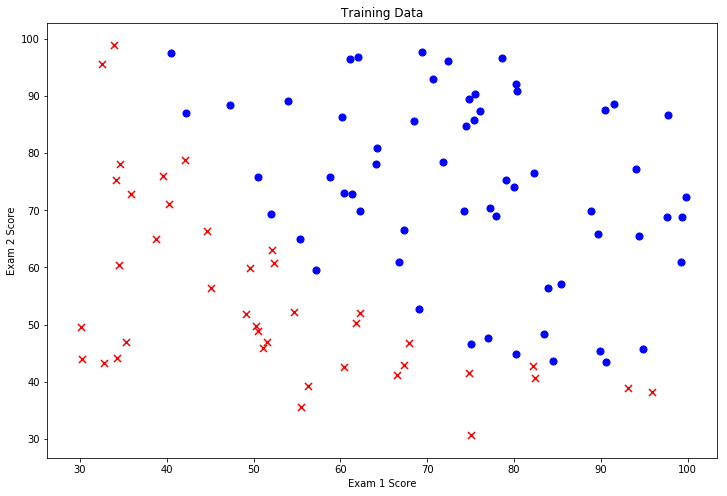

In [36]:
positive = data[data['Admitted'].isin([1])]  
negative = data[data['Admitted'].isin([0])]
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(positive['Exam 1'], positive['Exam 2'], s=50, c='b', marker='o', label='Admitted')  
ax.scatter(negative['Exam 1'], negative['Exam 2'], s=50, c='r', marker='x', label='Not Admitted') 
ax.set_xlabel('Exam 1 Score')  
ax.set_ylabel('Exam 2 Score')
ax.set_title('Training Data')

<h3> Sigmoid function </h3>

$$g(z) = \frac{1}{1+e^{-z}}$$

In [76]:
def sigmoid(z):  
    return 1 / (1 + np.exp(-z))

<h3>Plotting sigmoid function</h3>

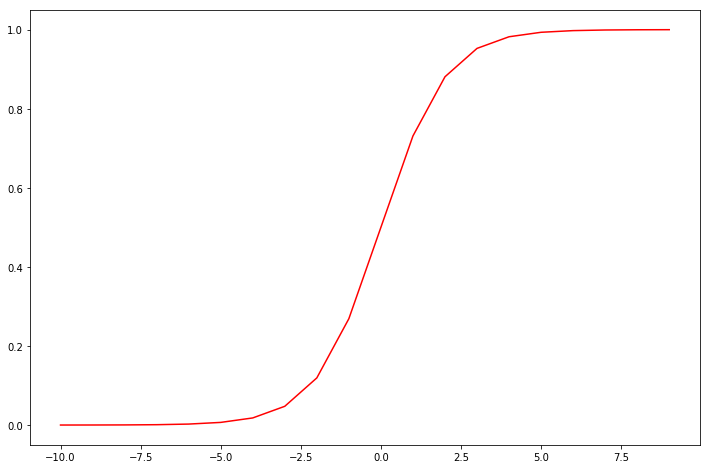

In [77]:
nums = np.arange(-10, 10, step=1)
fig, ax = plt.subplots(figsize=(12,8))  
ax.plot(nums, sigmoid(nums), 'r') 

<h3> Define Cost Function </h3>

<b>Hypothesis</b>

$$
  h_\theta(x) = g(\theta^T x)  
$$

<b>Cost Function</b>

\begin{equation}
 J(\theta) =- \frac{1}{m} \sum_{i=1}^{m}( y^i log(h_\theta(x^i)) + (1-y^i) log(1-h_\theta(x^i)))
\end{equation}

<b>Cost Function Vectorized Form</b>

$$
 h = g(X\Theta) \\
 J(\theta) = \frac{1}{m}(-y^T log(h) - (1-y)^T log(1-h))
$$

In [40]:
def costFunction(theta, X, y):  
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)
    first = np.multiply(-y, np.log(sigmoid(X * theta.T)))
    second = np.multiply((1 - y), np.log(1 - sigmoid(X * theta.T)))
    return np.sum(first - second) / (len(X))

In [41]:
# add a ones column - this makes the matrix multiplication work out easier
data.insert(0, 'Ones', 1)

# set X (training data) and y (target variable)
cols = data.shape[1]  
X = data.iloc[:,0:cols-1]  
y = data.iloc[:,cols-1:cols]

# convert to numpy arrays and initalize the parameter array theta
X = np.array(X.values)  
y = np.array(y.values)  
theta = np.zeros(3)

In [42]:
X.shape, y.shape, theta.T.shape

((100, 3), (100, 1), (3,))

In [43]:
costBefore = costFunction(theta,X,y)
costBefore

0.69314718055994529

<h3> Define Gradient Descent Function </h3>

\begin{equation}
\theta_0 := \theta_0 * \alpha \frac{1}{m} \sum_{i=1}^{m} (h_\theta(x^i)-y^i) (x_0^i) \\
\theta_j := \theta_j * \alpha \frac{1}{m} \sum_{i=1}^{m} (h_\theta(x^i)-y^i) (x_j^i) + \frac\lambda {m} \theta_j
\end{equation}

In [44]:
def gradient(theta, X, y):  
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)

    parameters = int(theta.ravel().shape[1])
    grad = np.zeros(parameters)

    error = sigmoid(X * theta.T) - y

    for i in range(parameters):
        term = np.multiply(error, X[:,i])
        grad[i] = np.sum(term) / len(X)

    return grad

Note that we don't actually perform gradient descent in this function - we just compute a single gradient step. In the exercise, an Octave function called "fminunc" is used to optimize the parameters given functions to compute the cost and the gradients. Since we're using Python, we can use SciPy's optimization API to do the same thing.

<h3>Why using optimization function?</h3>
<br>
In the previous assignment, you found the optimal parameters of a linear regression model by implementing gradent descent. You wrote a cost function and calculated its gradient, then took a gradient descent step accordingly. This time, instead of taking gradient descent steps, you will use an python built-in function called fmin_tnc.

In [45]:
import scipy.optimize as opt  
result = opt.fmin_tnc(func=costFunction, x0=theta, fprime=gradient, args=(X, y)) 
print('result ====>',result)
costAfter = costFunction(result[0], X, y)
print('costAfter =======>',costAfter)

result ====> (array([-25.16131861,   0.20623159,   0.20147149]), 36, 0)
costAfter =======> 0.203497701589


In [46]:
costBefore - costAfter

0.48964947897047068

<h3>Prediction Function</h3>

In [47]:
def predict(theta, X):  
    probability = sigmoid(X * theta.T)
    return [1 if x >= 0.5 else 0 for x in probability]

theta_min = np.matrix(result[0])  
predictions = predict(theta_min, X)  
correct = [1 if ((a == 1 and b == 1) or (a == 0 and b == 0)) else 0 for (a, b) in zip(predictions, y)]  
accuracy = (sum(map(int, correct)) % len(correct)) 
print ("Accuracy: %s%%\n" %accuracy)

Accuracy: 89%



Our logistic regression classifer correctly predicted if a student was admitted or not 89% of the time. Not bad! Keep in mind that this is training set accuracy though.

<h3>Regularized Logistic Regression</h3>

Now that we have a working implementation of logistic regression, we'll going to improve the algorithm by adding regularization. Regularization is a term in the cost function that causes the algorithm to prefer "simpler" models (in this case, models will smaller coefficients). The theory is that this helps to minimize overfitting and improve the model's ability to generalize. We’ll apply our regularized version of logistic regression to a slightly more challenging problem. Suppose you are the product manager of the factory and you have the test results for some microchips on two different tests. From these two tests, you would like to determine whether the microchips should be accepted or rejected. To help you make the decision, you have a data set of test results on past microchips, from which you can build a logistic regression model.

In [60]:
path = os.getcwd() + '/data/ex2data2.txt'  
data2 = pd.read_csv(path, header=None, names=['Test 1', 'Test 2', 'Accepted'])
data2.head()

,Test 1,Test 2,Accepted
0,0.051267,0.69956,1
1,-0.092742,0.68494,1
2,-0.213710,0.69225,1
3,-0.375000,0.50219,1
4,-0.513250,0.46564,1


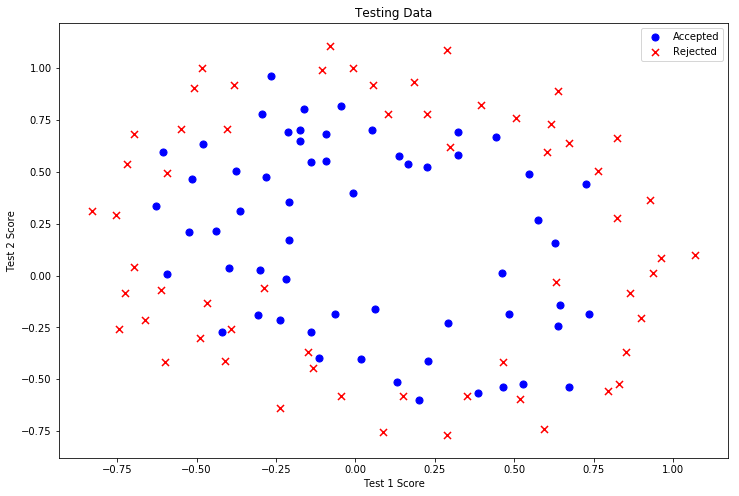

In [61]:

positive = data2[data2['Accepted'].isin([1])]  
negative = data2[data2['Accepted'].isin([0])]

fig, ax = plt.subplots(figsize=(12,8))  
ax.scatter(positive['Test 1'], positive['Test 2'], s=50, c='b', marker='o', label='Accepted')  
ax.scatter(negative['Test 1'], negative['Test 2'], s=50, c='r', marker='x', label='Rejected')  
ax.legend()  
ax.set_xlabel('Test 1 Score')  
ax.set_ylabel('Test 2 Score')  
ax.set_title('Testing Data')

<h3> Why using this kind of technique?</h3>

This data looks a bit more complicated than the previous example. In particular, you'll notice that there is no linear decision boundary that will perform well on this data. One way to deal with this using a linear technique like logistic regression is to construct features that are derived from polynomials of the original features. We can try creating a bunch of polynomial features to feed into the classifier.

In [49]:
degree = 5  
x1 = data2['Test 1']  
x2 = data2['Test 2']

data2.insert(3, 'Ones', 1)

for i in range(1, degree):  
    for j in range(0, i):
        data2['F' + str(i) + str(j)] = np.power(x1, i-j) * np.power(x2, j)

data2.drop('Test 1', axis=1, inplace=True)  
data2.drop('Test 2', axis=1, inplace=True)

data2.head()  

,Accepted,Ones,F10,F20,F21,F30,F31,F32,F40,F41,F42,F43
0,1,1,0.051267,0.002628,0.035864,0.000135,0.001839,0.025089,0.000007,0.000094,0.001286,0.017551
1,1,1,-0.092742,0.008601,-0.063523,-0.000798,0.005891,-0.043509,0.000074,-0.000546,0.004035,-0.029801
2,1,1,-0.213710,0.045672,-0.147941,-0.009761,0.031616,-0.102412,0.002086,-0.006757,0.021886,-0.070895
3,1,1,-0.375000,0.140625,-0.188321,-0.052734,0.070620,-0.094573,0.019775,-0.026483,0.035465,-0.047494
4,1,1,-0.513250,0.263426,-0.238990,-0.135203,0.122661,-0.111283,0.069393,-0.062956,0.057116,-0.051818


Now we need to modify the cost and gradient functions to include the regularization term. In each case, the regularizer is added on to the previous calculation. Here’s the updated cost function.

In [50]:
def costReg(theta, X, y, learningRate):  
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)
    first = np.multiply(-y, np.log(sigmoid(X * theta.T)))
    second = np.multiply((1 - y), np.log(1 - sigmoid(X * theta.T)))
    reg = (learningRate / 2 * len(X)) * np.sum(np.power(theta[:,1:theta.shape[1]], 2))
    return np.sum(first - second) / (len(X)) + reg

In [51]:
def gradientReg(theta, X, y, learningRate):  
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)

    parameters = int(theta.ravel().shape[1])
    grad = np.zeros(parameters)

    error = sigmoid(X * theta.T) - y

    for i in range(parameters):
        term = np.multiply(error, X[:,i])

        if (i == 0):
            grad[i] = np.sum(term) / len(X)
        else:
            grad[i] = (np.sum(term) / len(X)) + ((learningRate / len(X)) * theta[:,i])

    return grad

<h3> Testing The New Cost Function </h3>

In [52]:
# set X and y (remember from above that we moved the label to column 0)
cols = data2.shape[1]  
X2 = data2.iloc[:,1:cols]  
y2 = data2.iloc[:,0:1]

# convert to numpy arrays and initalize the parameter array theta
X2 = np.array(X2.values)  
y2 = np.array(y2.values)  
theta2 = np.zeros(11) 

In [68]:
learningRate = 0.000001

In [69]:
costReg(theta2, X2, y2, learningRate) 

0.6931471805599454

In [70]:
gradientReg(theta2, X2, y2, learningRate)

array([ 0.00847458,  0.01878809,  0.05034464,  0.01150133,  0.01835599,
        0.00732393,  0.00819244,  0.03934862,  0.00223924,  0.01286005,
        0.00309594])

In [71]:
result2 = opt.fmin_tnc(func=costReg, x0=theta2, fprime=gradientReg, 
                       args=(X2, y2, learningRate))
result2

(array([  0.79755328,   1.04532484,   4.46133252,  -7.47929461,
          2.11743333,   6.11026584,  -1.19496932, -11.81491227,
          2.48935671, -22.92609615,   6.87510376]), 96, 4)

<h3>New Prediction Accuracy</h3>

In [72]:
theta_min = np.matrix(result2[0])  
predictions = predict(theta_min, X2)  
correct = [1 if ((a == 1 and b == 1) or (a == 0 and b == 0)) else 0 for (a, b) in zip(predictions, y2)]  
accuracy = (sum(map(int, correct)) % len(correct))  
print ("Accuracy: %s%%\n" %accuracy)

Accuracy: 90%

